# Trains a model which returns whether a message is a request for help

In [26]:
# Imports
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import requests
import sys
import random
import pydot
import csv
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from tqdm.notebook import trange, tqdm
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
# Parameters
BATCH_SIZE = 32
VALIDATION_RATIO=0.1
MODEL_NAME = "help_and_support"
LABELS = ["Yes", "No"]

EPOCHS = 10

In [228]:
# Gather input data

columns = ['is_help_request', 'text']
input_columns = len(columns)
rows = []

url = "https://docs.google.com/spreadsheets/d/1qKpHCNOVqBrU1OxFLgV_Z0lEE0cJTdOdm-aZ1soDaag/export?format=csv&gid=1802577011"

csvfile = requests.get(url).content.decode('utf-8')

reader = csv.reader(csvfile.splitlines(), delimiter=",", )
next(reader) # Skip header
for row in reader:
    if len(row) == 0:
        continue
    rows.append(
        list(row.copy())
    )

# TODO: Should probably add class weights if we have an imbalanced dataset
#class_weights = {}
#for i, e in enumerate(class_counts):
#    class_weights[i] = (1 / class_counts[i]) * (len(rows) / 5.0)
#print(F"Class weight result: {class_weights}")

print(F"Read {len(rows)} rows")
num_rows = len(rows)
random.shuffle(rows)

# Create a new Numpy array with just labels
inputs = np.array(list(
    map(lambda x: x[1], rows.copy()
)))
labels = np.array(list(
    map(lambda x: float(x[0]), rows.copy()
)))
print(F"Loaded {num_rows} rows")

Read 504 rows
Loaded 504 rows


In [231]:
# Create a dataset & split it into training & validation
dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
val_size = int(num_rows * VALIDATION_RATIO)
print(F"Creating training dataset n={num_rows - val_size}")
print(F"Creating validation dataset n={val_size}")
raw_train_ds = dataset.skip(val_size).batch(BATCH_SIZE)
raw_val_ds = dataset.take(val_size).batch(BATCH_SIZE)

Creating training dataset n=454
Creating validation dataset n=50


In [276]:
# Vectorize inputs
max_features = 5000
sequence_length = 150

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [277]:
# Define models

# 8-dimension embedding is a reasonable choice for our small dataset. If we grow past ~5000 examples, maybe tick this up a bit.
embedding_dim = 8

models = {}
models['simple'] = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])
models['simple'].summary()
models['simple'].compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

for name, model in models.items():
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 8)           40008     
                                                                 
 dropout_88 (Dropout)        (None, None, 8)           0         
                                                                 
 global_average_pooling1d_44  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_89 (Dropout)        (None, 8)                 0         
                                                                 
 dense_44 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,017
Trainable params: 40,017
Non-trainable params: 0
________________________________________________

Fitting simple...


Training:   0%|                                                                                               …

Epoch 1/10


0/15                                                                                                          …

Epoch 2/10


0/15                                                                                                          …

Epoch 3/10


0/15                                                                                                          …

Epoch 4/10


0/15                                                                                                          …

Epoch 5/10


0/15                                                                                                          …

Epoch 6/10


0/15                                                                                                          …

Epoch 7/10


0/15                                                                                                          …

Epoch 8/10


0/15                                                                                                          …

Epoch 9/10


0/15                                                                                                          …

Epoch 10/10


0/15                                                                                                          …

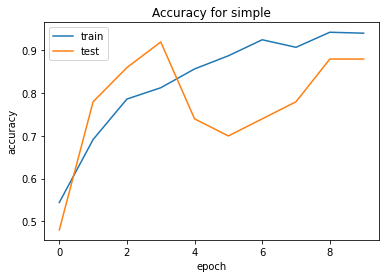

In [278]:
# Fit the model
for name, model in models.items():
    print(F"Fitting {name}...")
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS,
      callbacks=[
          tfa.callbacks.TQDMProgressBar(),
          keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
      ],
      #class_weight=class_weights,
      verbose=0,
    )
    # Show the loss over time
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title(F'Accuracy for {name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [279]:
# Create a model that's ready to use

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Save it
export_model.save(F'../saved_model/{MODEL_NAME}_' + name + datetime.now().strftime('%Y-%m-%dT%H:%M:%S.%f%z'))

# Test it
inputs = [
    "Hey guys, I'm new here, can I get some help setting up ELRS?",
    "I can't seem to get my Mobula 6 to bind with my TX16S",
    "Hi guys, I'm new to ELRS and excited to fly since I'm all set up!",
    "Can anyone help me figure out why my link drops when I use VTX Admin?",
    "I just got a Crux 3 and can't figure out how to set up the SPI receiver, anyone know how to do that?",
    "Is there anyone here who has experience with the Crux 3 and the Jumper T-Pro?",
    "How do I turn off model match?",
    "How do I flash an RX with the TX firmware?",
    "Thanks for all the help and support!",
    "Hey guys how's everyone doing?",
    "Why would I want to use that?",
    "I solder things with a copper block",
    "What time is it?",
    "A TCXO is a fixed-frequency crystal, not affected by temperature",
    "Could you do me a favor?",
    "Should I take general chat maybe?",
    "You should connect to the WiFi and use the /hardware.html page",
    "Thanks for the link! That's awesome",
    "What?",
]

results = export_model.predict(inputs, verbose=0)
results_percentages = list(map(lambda x: round(x[0] * 100), results.tolist()))
for i in range(len(results)):
    print(f"{results_percentages[i]}% confidence: \"{inputs[i]}\" ") 

INFO:tensorflow:Assets written to: ../saved_model/help_and_support_simple2023-01-09T17:55:21.540697/assets
98% confidence: "Hey guys, I'm new here, can I get some help setting up ELRS?" 
99% confidence: "I can't seem to get my Mobula 6 to bind with my TX16S" 
86% confidence: "Hi guys, I'm new to ELRS and excited to fly since I'm all set up!" 
99% confidence: "Can anyone help me figure out why my link drops when I use VTX Admin?" 
89% confidence: "I just got a Crux 3 and can't figure out how to set up the SPI receiver, anyone know how to do that?" 
85% confidence: "Is there anyone here who has experience with the Crux 3 and the Jumper T-Pro?" 
83% confidence: "How do I turn off model match?" 
89% confidence: "How do I flash an RX with the TX firmware?" 
30% confidence: "Thanks for all the help and support!" 
67% confidence: "Hey guys how's everyone doing?" 
71% confidence: "Why would I want to use that?" 
67% confidence: "I solder things with a copper block" 
59% confidence: "What time 